In [49]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

HOST = 'localhost'
PORT = 27010

# Load Dataset

random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    print(size)
    for i in range(size):
        idx = int(random.random()*size)
        thumb = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)

print('ok')
    

4067
ok


In [59]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [50]:
from matplotlib import pyplot as plt
def show_results(history, hidden_layers, hidden_layer_units):

    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{hidden_layers}_hidden_layers_{hidden_layer_units}_units Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    acc = history.history['mae']
    val_acc = history.history['val_mae']
    plt.plot(epochs, acc, 'y', label='Training MAE')
    plt.plot(epochs, val_acc, 'r', label='Validation MAE')
    plt.title(f'{hidden_layers}_hidden_layers_{hidden_layer_units}_units Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import io
import random
import numpy as np
import base64
from sklearn.model_selection import train_test_split

# Parameters
HOST = 'localhost'
PORT = 27010
IMG_WIDTH, IMG_HEIGHT = 128, 128  # Resize images to a fixed size
NUM_IMAGES = 4067  # Number of images to load for training

def load_and_preprocess_image(thumb):
    image = thumb.jpg  # Assuming thumb.jpg is already a JpegImageFile object
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))

    # Splitting the image into 4 patches
    patches = []
    for i in range(2):
        for j in range(2):
            left = i * IMG_WIDTH // 2
            upper = j * IMG_HEIGHT // 2
            right = (i + 1) * IMG_WIDTH // 2
            lower = (j + 1) * IMG_HEIGHT // 2
            patch = image.crop((left, upper, right, lower))
            patches.append(np.array(patch) / 255.0)  # Normalize pixel values

    return patches

# Initialize Mongo connection
mongo_info = MongoInfo(host=HOST, port=PORT)
images = []
labels = []

with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    indices = random.sample(range(size), NUM_IMAGES)
    for idx in indices:
        thumb = thumb_api.read(idx)
        image_patches = load_and_preprocess_image(thumb)
        images.extend(image_patches)
        labels.extend([float(thumb.measurement.val_1m)] * 4)  # Extracting label for each patch

images = np.array(images)
labels = np.array(labels)  # Convert labels list to numpy array

# Split the dataset into training and test sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, shuffle=True)

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import load_model



# def nnetwork(hidden_layers, hidden_layer_units):
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def nnetwork(num_conv_layers, num_filters):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(64, 64, 3)))

    for i in range(num_conv_layers):
        if i < num_conv_layers - 1:  # Add padding for all but the last conv layer
            model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.Conv2D(num_filters, (3, 3), activation='relu'))  # No padding for the last conv layer

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    # return model

    # NN_model = Sequential()

    # # Add a Flatten layer to convert 3D data to 1D
    # NN_model.add(Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))

    # # The Input Layer
    # NN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))

    # # The Hidden Layers
    # for _ in range(hidden_layers):
    #     NN_model.add(Dense(hidden_layer_units, kernel_initializer='normal', activation='relu'))

    # # The Output Layer
    # NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # # Compile the network
    # NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
    # return NN_model

    # saving and loading the .h5 model
 
    # save model
    h5_path = f"D:/TELLUS/Calcimetrie/ai.calcimetry/pkl_models/DeepReg_NN_{num_conv_layers}_hidden_layers_{num_filters}_units.h5"
    model.save(h5_path)
    print('Model Saved!')
    
    # load model
    savedModel=load_model(h5_path)
    savedModel.summary()
    return model

In [58]:
model_5_512 = nnetwork(5, 512)
history = model_5_512.fit(X_train, y_train, epochs =10, validation_data=(X_test, y_test))
show_results(history, 5, 512)


Model Saved!
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 64, 64, 512)       14336     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 512)       2359808   
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 512)       2359808   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 

KeyboardInterrupt: 

115/115 [==============================] - 2s 14ms/step


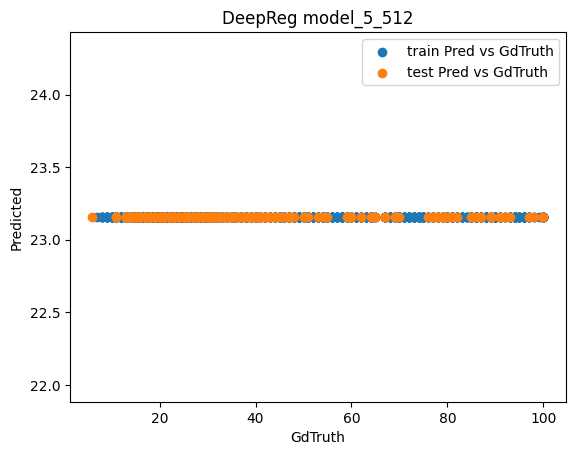

In [ ]:
y_test_predicted = model_5_512.predict(X_test)
y_train_predicted = model_5_512.predict(X_train)



# plt.scatter(train_y, y_train_predicted)
# plt.scatter(test_y, y_test_predicted)

plt.title('DeepReg model_5_512')

plt.scatter(y_train, y_train_predicted, label='train Pred vs GdTruth')
plt.scatter(y_test, y_test_predicted,  label='test Pred vs GdTruth')
plt.xlabel('GdTruth')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.show()

Model Saved!
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 49152)             0         
                                                                 
 dense_220 (Dense)           (None, 128)               6291584   
                                                                 
 dense_221 (Dense)           (None, 256)               33024     
                                                                 
 dense_222 (Dense)           (None, 256)               65792     
                                                                 
 dense_223 (Dense)           (None, 256)               65792     
                                                                 
 dense_224 (Dense)           (None, 256)               65792     
                                                                 
 dense_225 (Dense)           (None, 256)

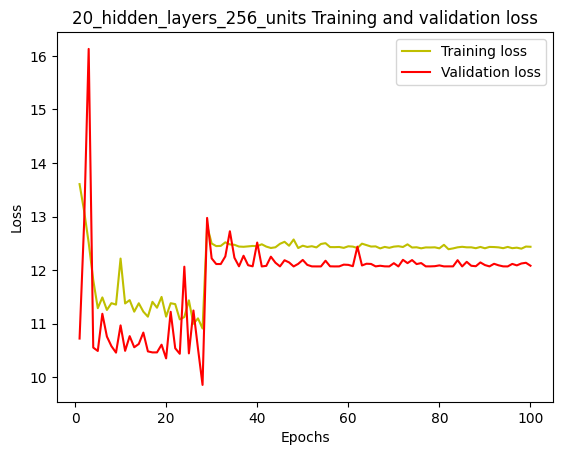

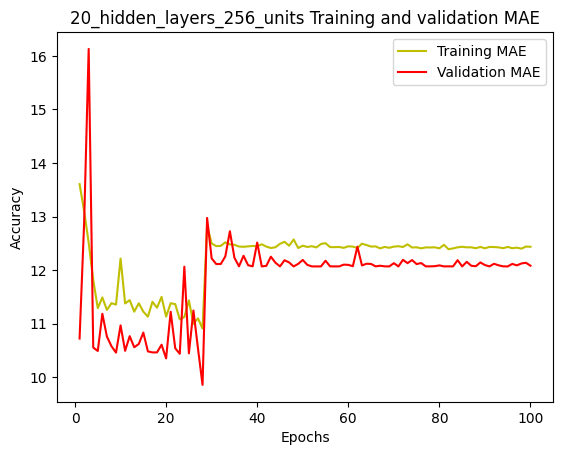

115/115 [==============================] - 2s 17ms/step


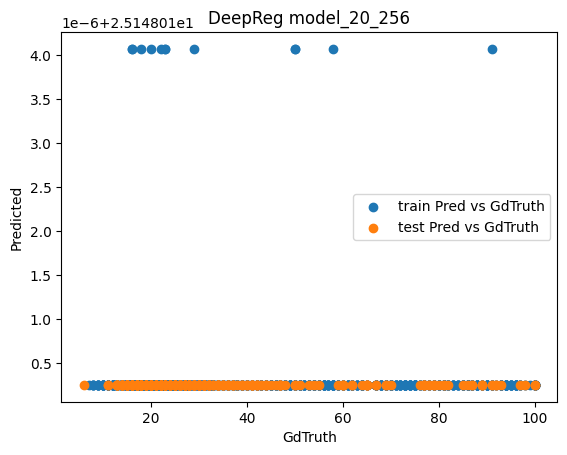

In [ ]:
model_20_256 = nnetwork(20, 256)
history = model_20_256.fit(X_train, y_train, epochs =100, validation_data=(X_test, y_test))
show_results(history, 20, 256)


y_test_predicted = model_20_256.predict(X_test)
y_train_predicted = model_20_256.predict(X_train)



# plt.scatter(train_y, y_train_predicted)
# plt.scatter(test_y, y_test_predicted)

plt.title('DeepReg model_20_256')

plt.scatter(y_train, y_train_predicted, label='train Pred vs GdTruth')
plt.scatter(y_test, y_test_predicted,  label='test Pred vs GdTruth')
plt.xlabel('GdTruth')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.show()


### Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import io
import random
import numpy as np
import base64
from sklearn.model_selection import train_test_split

# Parameters
HOST = 'localhost'
PORT = 27010
IMG_WIDTH, IMG_HEIGHT = 128, 128  # Resize images to a fixed size
NUM_IMAGES = 4067  # Number of images to load for training

# Define data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,       # Random rotations from 0-20 degrees
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'
)

def load_and_preprocess_image(thumb, augment=True):
    image = thumb.jpg  # Assuming thumb.jpg is already a JpegImageFile object
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))

    # Splitting the image into 4 patches
    patches = []
    for i in range(2):
        for j in range(2):
            left = i * IMG_WIDTH // 2
            upper = j * IMG_HEIGHT // 2
            right = (i + 1) * IMG_WIDTH // 2
            lower = (j + 1) * IMG_HEIGHT // 2
            patch = image.crop((left, upper, right, lower))

            # Apply data augmentation
            if augment:
                patch = data_augmentation.random_transform(np.array(patch))

            patches.append(np.array(patch) / 255.0)  # Normalize pixel values

    return patches

# Initialize Mongo connection
mongo_info = MongoInfo(host=HOST, port=PORT)
images = []
labels = []

# Load and process images
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    indices = random.sample(range(size), NUM_IMAGES)
    for idx in indices:
        thumb = thumb_api.read(idx)
        image_patches = load_and_preprocess_image(thumb, augment=True)  # Augment images
        images.extend(image_patches)
        labels.extend([float(thumb.measurement.val_1m)] * 4)  # Extracting label for each patch

images = np.array(images)
labels = np.array(labels)  # Convert labels list to numpy array

# Split the dataset into training and test sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import load_model
from keras.layers import Flatten

def nnetwork(hidden_layers=5, hidden_layer_units=512):
    NN_model = Sequential()

    # Add a Flatten layer to convert 3D data (images) to 1D (flattened array)
    NN_model.add(Flatten(input_shape=(128, 128, 3)))

    # The Input Layer after flattening:
    NN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))

    # The Hidden Layers:
    for i in range(hidden_layers):
        NN_model.add(Dense(hidden_layer_units, kernel_initializer='normal', activation='relu'))

    # The Output Layer:
    NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile the network:
    NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    # saving and loading the .h5 model
 
    # # save model
    # h5_path = f"D:/TELLUS/Calcimetrie/ai.calcimetry/pkl_models/NN_{hidden_layers}_hidden_layers_{hidden_layer_units}_units.h5"
    # NN_model.save(h5_path)
    # print('Model Saved!')
    
    # # load model
    # savedModel=load_model(h5_path)
    # savedModel.summary()
    return NN_model

In [ ]:
# from sklearn.wrappers import KerasRegressor
# Wrap the Keras model using KerasRegressor
keras_wrapper = KerasRegressor(build_fn=nnetwork, epochs=100, batch_size=32, verbose=2)

d:\TELLUS\Calcimetrie\ai.calcimetry\calcimetry_env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


## 4-Fold DeepReg

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

# Perform 4-fold cross validation

scores = cross_val_score(keras_wrapper, images, labels, cv=4)
print("Cross-validated scores:", scores)

# Make cross-validated predictions
predictions = cross_val_predict(keras_wrapper, images, labels, cv=4)
plt.scatter(labels, predictions)
accuracy = r2_score(labels, predictions)

print("Cross-Predicted Accuracy:", accuracy)

Epoch 1/100
96/96 - 15s - loss: 343.4471 - mae: 13.1395 - 15s/epoch - 158ms/step
Epoch 2/100
96/96 - 13s - loss: 290.9060 - mae: 12.3618 - 13s/epoch - 139ms/step
Epoch 3/100
96/96 - 14s - loss: 270.5661 - mae: 12.0278 - 14s/epoch - 146ms/step
Epoch 4/100
96/96 - 13s - loss: 263.7076 - mae: 11.8712 - 13s/epoch - 138ms/step
Epoch 5/100
96/96 - 13s - loss: 255.8351 - mae: 11.6853 - 13s/epoch - 138ms/step
Epoch 6/100
96/96 - 13s - loss: 266.7733 - mae: 11.8999 - 13s/epoch - 138ms/step
Epoch 7/100
96/96 - 14s - loss: 254.2841 - mae: 11.6217 - 14s/epoch - 144ms/step
Epoch 8/100
96/96 - 13s - loss: 259.7883 - mae: 11.7820 - 13s/epoch - 139ms/step
Epoch 9/100
96/96 - 13s - loss: 261.8211 - mae: 11.8674 - 13s/epoch - 139ms/step
Epoch 10/100
96/96 - 14s - loss: 255.7549 - mae: 11.6691 - 14s/epoch - 144ms/step
Epoch 11/100
96/96 - 15s - loss: 253.9964 - mae: 11.6716 - 15s/epoch - 159ms/step
Epoch 12/100
96/96 - 14s - loss: 254.7989 - mae: 11.7500 - 14s/epoch - 143ms/step
Epoch 13/100
96/96 - 14s 

KeyboardInterrupt: 

ajouter 

In [ ]:
# predictions = cross_val_predict(keras_wrapper, x, y, cv=4)


# plt.scatter(train_y, y_train_predicted, label='train Pred vs GdTruth')
# plt.scatter(test_y, y_test_predicted,  label='test Pred vs GdTruth')
plt.xlabel('GdTruth')
plt.ylabel('Predicted')
plt.scatter(labels, predictions)
plt.title('4-Fold NN_5_512')
plt.legend(loc='best')
plt.show()

# plt.xlabel('true')
# plt.ylabel('predicted')

d:\TELLUS\Calcimetrie\ai.calcimetry\calcimetry_env\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.


Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...


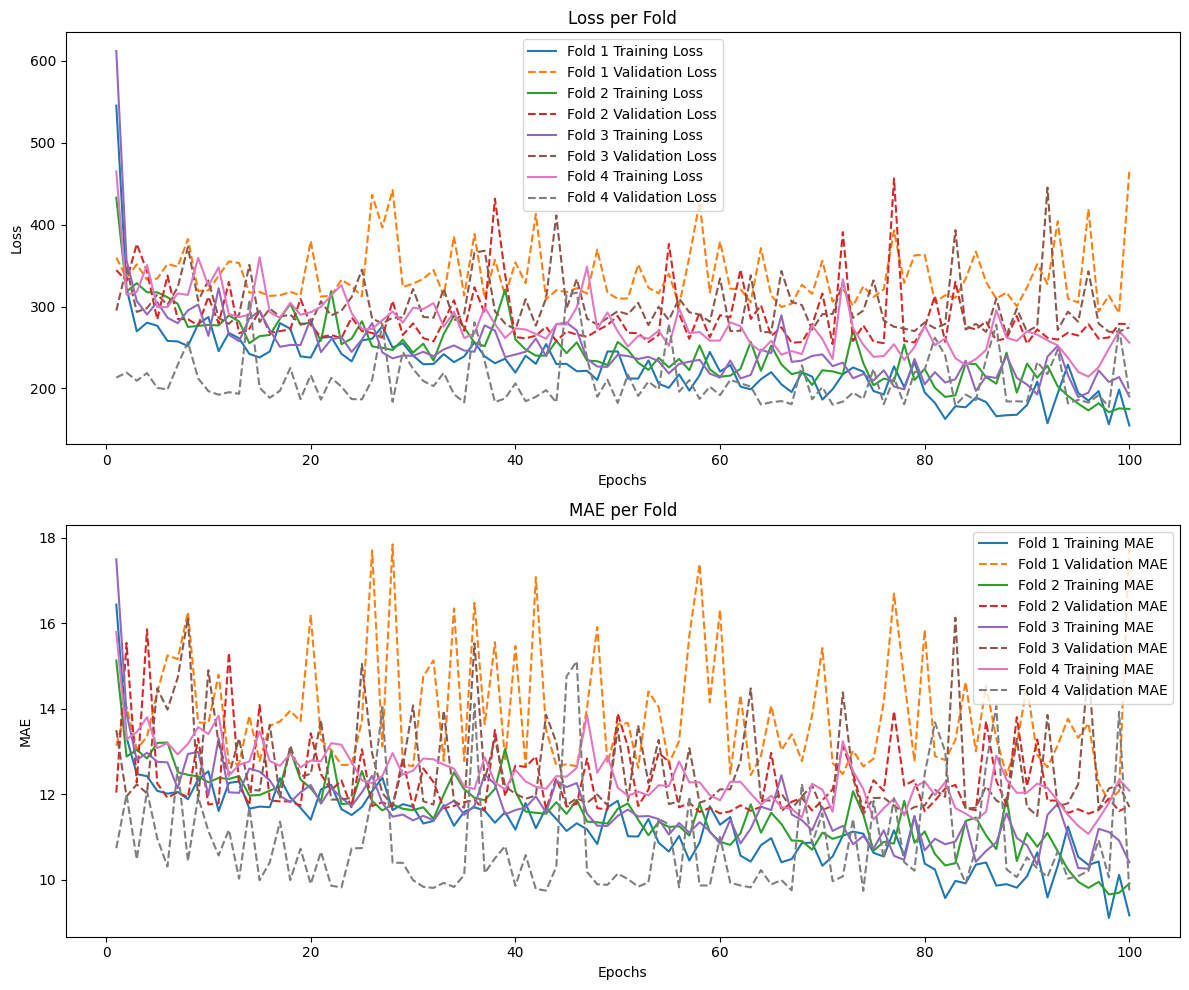

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_absolute_error, r2_score

# Function to calculate adjusted R-squared
def adjusted_r_squared(r_squared, n, k):
    return 1 - ((1 - r_squared) * (n - 1)) / (n - k - 1)


# Wrap the Keras model using KerasRegressor
keras_wrapper = KerasRegressor(build_fn=nnetwork, epochs=100, batch_size=32, verbose=0)

# Perform 4-fold cross-validation manually
kf = KFold(n_splits=4, shuffle=True)
fold = 0
histories = []

# Additional code to compute R-squared and Adjusted R-squared
r2_scores = []
adj_r2_scores = []
mae_scores = []


for train_index, test_index in kf.split(images):
    fold += 1
    print(f"Training on fold {fold}/4...")
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    history = keras_wrapper.fit(X_train, y_train, validation_data=(X_test, y_test))
    histories.append(history.history)

    # Predicting on test set
    y_pred = keras_wrapper.model.predict(X_test)

    # Calculating R-squared and MAE
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)

    # Calculating Adjusted R-squared
    # n is the number of samples and k is the number of independent variables
    n = X_test.shape[0]
    k = X_test.shape[1]
    adj_r2 = adjusted_r_squared(r2, n, k)
    adj_r2_scores.append(adj_r2)

# Plotting
epochs = range(1, 101)  # Adjust this based on your epochs
plt.figure(figsize=(12, 10))

# Plotting Loss
plt.subplot(2, 1, 1)
for i, history in enumerate(histories):
    plt.plot(epochs, history['loss'], label=f'Fold {i+1} Training Loss')
    plt.plot(epochs, history['val_loss'], label=f'Fold {i+1} Validation Loss', linestyle="--")
plt.title('Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Printing average scores across all folds
print("Average R-squared:", np.mean(r2_scores))
print("Average Adjusted R-squared:", np.mean(adj_r2_scores))
print("Average MAE:", np.mean(mae_scores))


# Plotting MAE
plt.subplot(2, 1, 2)
for i, history in enumerate(histories):
    plt.plot(epochs, history['mae'], label=f'Fold {i+1} Training MAE')
    plt.plot(epochs, history['val_mae'], label=f'Fold {i+1} Validation MAE', linestyle="--")
plt.title('MAE per Fold')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


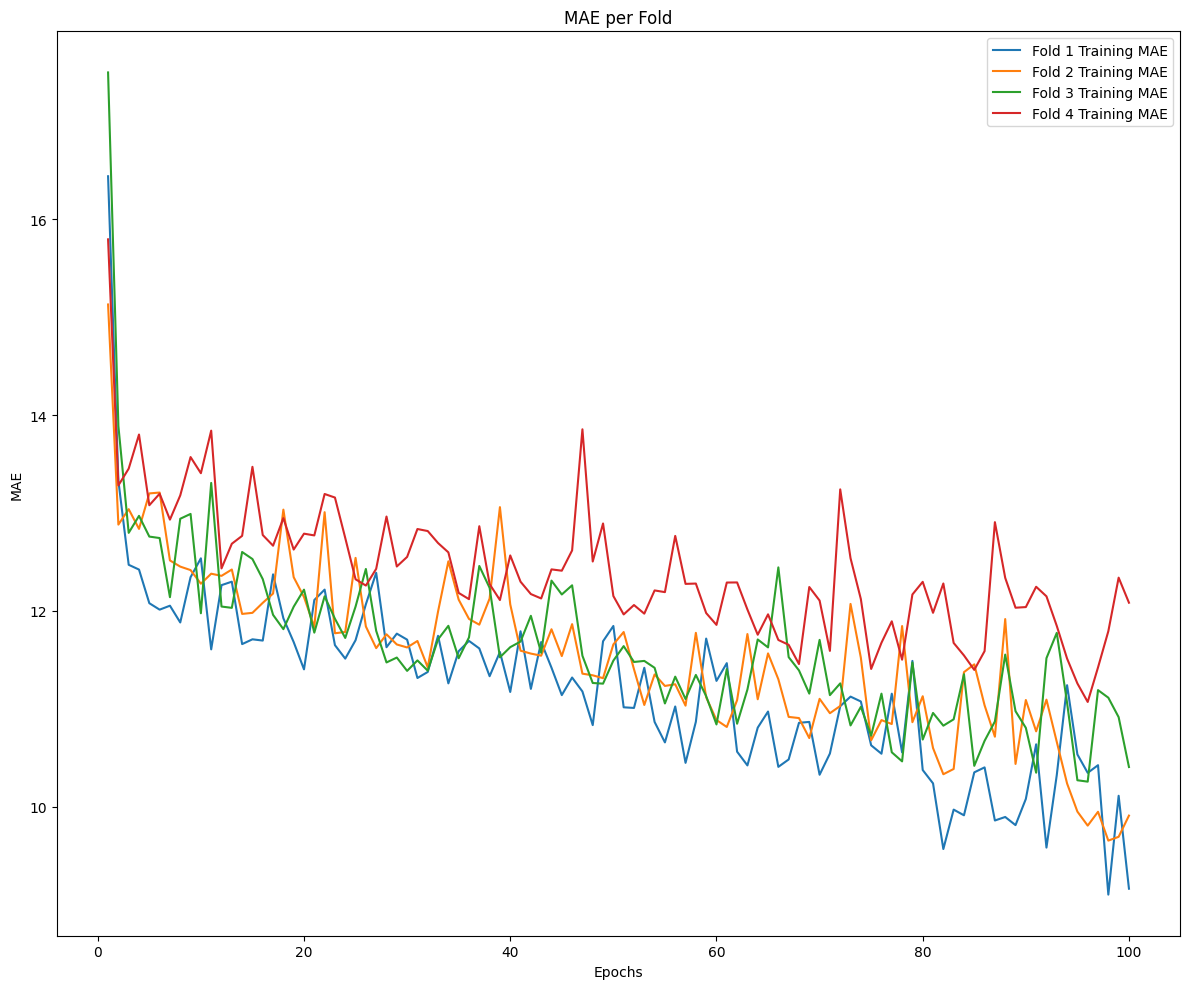

In [ ]:
# Plotting
epochs = range(1, 101)  # Adjust this based on your epochs
plt.figure(figsize=(12, 10))
plt.subplot(1, 1, 1)


# Plotting MAE
# plt.subplot(2, 1, 2)
for i, history in enumerate(histories):
    plt.plot(epochs, history['mae'], label=f'Fold {i+1} Training MAE')
    # plt.plot(epochs, history['val_mae'], label=f'Fold {i+1} Validation MAE', linestyle="--")
plt.title('MAE per Fold')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


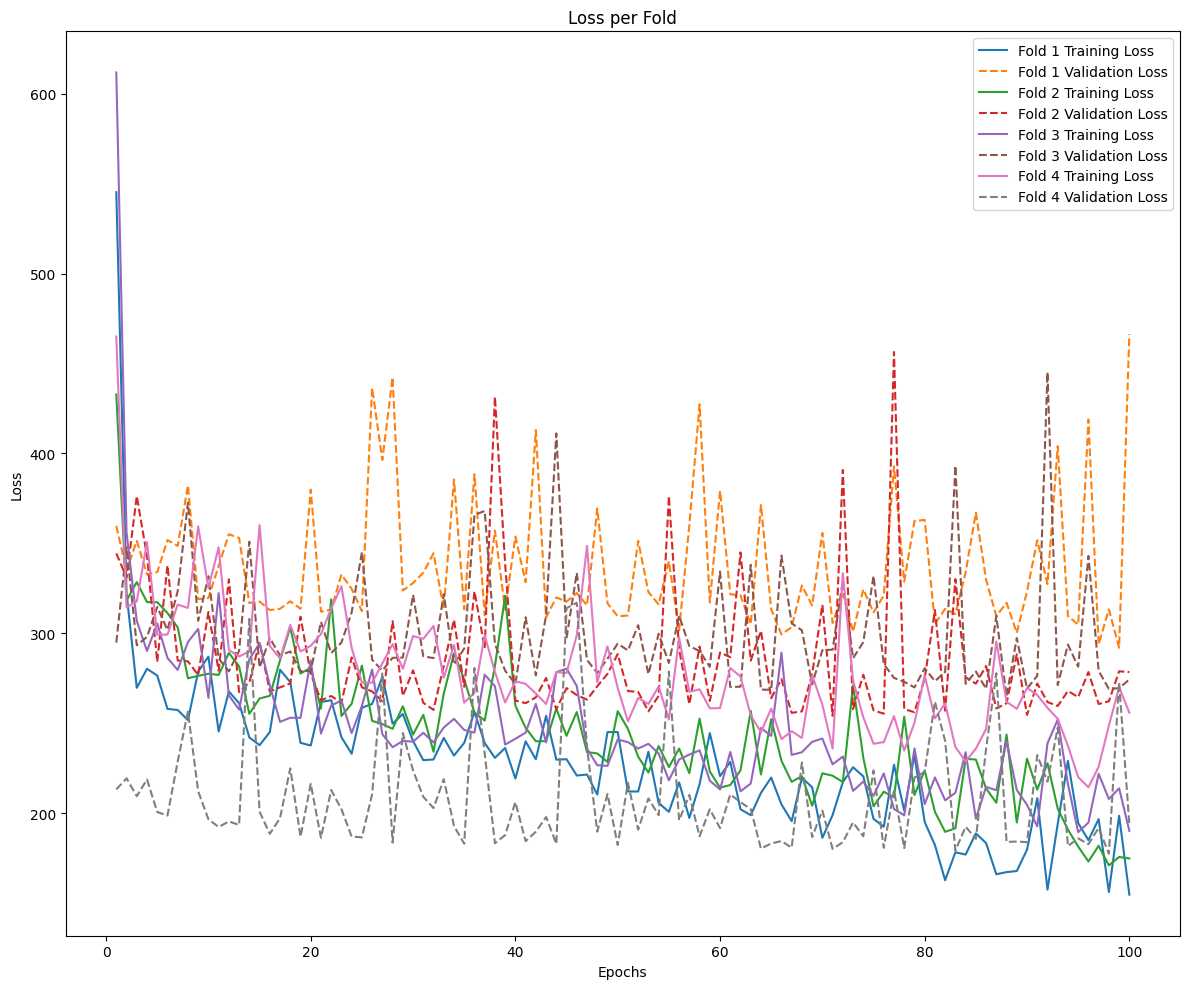

In [ ]:
# Plotting
epochs = range(1, 101)  # Adjust this based on your epochs
plt.figure(figsize=(12, 10))

# Plotting Loss
plt.subplot(1, 1, 1)
for i, history in enumerate(histories):
    plt.plot(epochs, history['loss'], label=f'Fold {i+1} Training Loss')
    plt.plot(epochs, history['val_loss'], label=f'Fold {i+1} Validation Loss', linestyle="--")
plt.title('Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### Objectif de l'expérience : 
Évaluation de la performance d'un modèle de régression profonde sur un ensemble de données spécifique via la validation croisée K-fold.

#### Méthodologie : 
Le modèle a été entraîné sur plusieurs sous-ensembles (folds) des données, avec chaque fold servant à la fois de set d'entraînement et de validation dans différentes itérations.

#### Métriques de performance :

##### Perte (Loss) : Utilisée pour mesurer l'erreur entre les prédictions du modèle et les valeurs réelles. Une valeur plus basse indique une meilleure performance.
Erreur Absolue Moyenne (MAE) : Moyenne de la valeur absolue des erreurs entre les prédictions et les valeurs réelles. Une valeur plus faible signifie que les prédictions sont en moyenne plus proches des valeurs réelles.

#### Résultats clés :

##### Amélioration au fil des epochs : 
Dans chaque fold, la perte et le MAE diminuent généralement avec plus d'epochs, indiquant que le modèle s'améliore avec l'entraînement.
##### Variabilité entre les folds : 
Il existe des variations dans les performances (perte et MAE) entre les différents folds. Cela peut indiquer une variabilité dans les données ou une sensibilité du modèle à l'initialisation.

#### Observations générales :

##### Tendance de convergence : 
Le modèle semble converger au fur et à mesure que le nombre d'epochs augmente, comme le montre la diminution de la perte et du MAE.
##### Considérations de performance : 
Bien que le modèle montre des signes d'apprentissage, la variabilité entre les folds suggère qu'une enquête supplémentaire sur la robustesse du modèle ou la qualité des données pourrait être nécessaire.

#### Recommandations pour les étapes suivantes :

##### Optimisation du modèle : 
Envisager d'ajuster les hyperparamètres, d'utiliser des techniques de régularisation, ou d'expérimenter avec différentes architectures de réseau pour améliorer la performance.
##### Analyse approfondie des données : 
Examiner la distribution des données pour identifier d'éventuelles anomalies ou biais qui pourraient affecter la performance du modèle.
##### Validation externe : 
Tester le modèle sur un ensemble de données externe pour évaluer sa capacité de généralisation.